In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyroounfold.roo_convertor import df_to_roounf, th1_to_arr
from pyroounfold.plotting import plot_compare_single_run, plot_compare_para, get_migration, get_bin_centers, get_bin_widths
from pyroounfold.unfold_methods import do_unfold
from pyroounfold.bias_study import get_fom

Welcome to JupyROOT 6.14/04


As an example, we create some artificial variables to play. In practical application, this can be skipped and start from reading in actual ntuples/rootfiles. 

Here, we use df_train to extract the response matrix, and df_test contains the measured data to be unfolded. In detail, the columns of df_train are filled by Breit-Wigner distribution as 'truth' and smeare it by Gaussian to be 'measured'. For df_test, 'truth' is a Gaussian and 'measured' is Gaussian smeared too. Event-wise weights (set as 1 in example) can be included. For a case of MC study, it could be useful(optional in code) to set the statistical uncerntainty of measured distubtion (use df_test as signal) as expected to be sqrt(#sig + #bkg) rathan than the default sqrt(#sig). Therefore, a Gaussian shaped background is prepared as well.

In [2]:
# Gaussian smearing function
import ROOT

def smear(xt):
    xsmear= ROOT.gRandom.Gaus(-2.5,0.2)
    return xt+xsmear;

df_train = pd.DataFrame(columns=['truth','measured', 'weight'])
df_test = pd.DataFrame(columns=['truth','measured', 'weight'])
df_bkg = pd.DataFrame(columns=['truth','measured', 'weight'])

df_train['truth'] = [ ROOT.gRandom.BreitWigner(0.3, 2.5) for x in range(100000)]
df_train['measured'] = smear(df_train['truth'])
df_train['weight'] = 1.

df_test['truth'] = [ ROOT.gRandom.Gaus(0.0, 2.0) for x in range(10000)]
df_test['measured'] = smear(df_test['truth'])
df_test['weight'] = 1.

# in case bkg sample needed for using expected statistical uncertianty 
df_bkg['truth'] = [ ROOT.gRandom.Gaus(0.0, 2.0) for x in range(8000)]
df_bkg['measured'] = smear(df_bkg['truth'])
df_bkg['weight'] = 1.

Here's the actual strat-point of this example. 
Define a binning for the artificial variable, then convert the needed columns from dataframe to histograms or matrix, which are inputs for RooUnfold.

In [3]:
my_bins = np.linspace(-10,10,41)

hist_train_true, hist_train_reco, respon_matrix, hist_test_true, hist_test_reco = df_to_roounf(
    train = df_train, 
    weight_train = df_train['weight'], 
    test = df_test, 
    weight_test = df_test['weight'], 
    true_name = 'truth', 
    reco_name = 'measured', 
    bins = my_bins
    # if one wants to use stat. uncertainty of (df_test + df_bkg), can enable following two para.
    # bkg=df_bkg,   
    # weight_bkg=df_bkg['weight']
    )


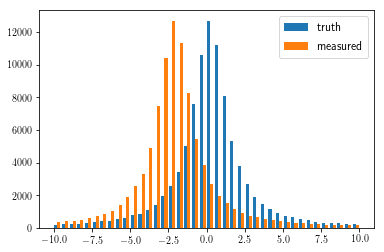

In [4]:
# have a look at the fictional data
plt.hist([df_train['truth'], df_train['measured']], label=['truth', 'measured'], bins = my_bins )
plt.legend(loc='upper right', prop={'size':12})
plt.show()
plt.close()

Now everything needed to launch unfolding is ready !!!

Let's give it a first try, e.g. SVD method with k=0 (default value will be taken by algorithm, i.e. #bins/2)

In [5]:
df_unf, cov_array = do_unfold( hist_test_true, hist_test_reco, respon_matrix, 'Svd', 0)

Use SVD method with regularisation number = 0.
SVD init 40 x 40 bins, kreg=20


Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 20
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.003797


<ROOT.RooUnfoldResponse object ("train_Adet_measured") at 0x7f807993d520>

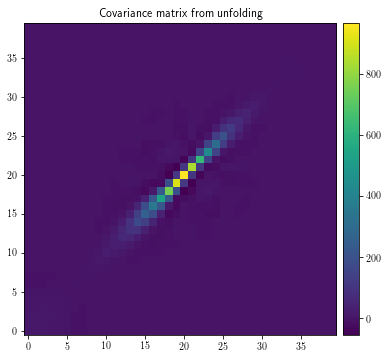

In [6]:
# have a look at the cov matrix from unfolding
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig_cov = plt.figure(figsize=(6, 6))

ax = fig_cov.add_subplot(111)
im = plt.imshow(cov_array, origin='low')
ax.set_title("Covariance matrix from unfolding")
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
    
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
plt.show()
plt.close()

In [7]:
df_unf

,bin_index,true_central,true_error,measured_central,measured_error,unfolded_central,unfolded_error
0,1,0.0,0.000000,3.0,1.732051,0.557234,3.505216
1,2,0.0,0.000000,5.0,2.236068,0.681334,3.539397
2,3,0.0,0.000000,6.0,2.449490,1.011481,3.716267
3,4,1.0,1.000000,22.0,4.690416,1.271691,2.909022
4,5,0.0,0.000000,34.0,5.830952,2.223960,2.722676
5,6,3.0,1.732051,47.0,6.855655,3.003067,1.545612
6,7,4.0,2.000000,102.0,10.099505,4.560288,1.664690
7,8,7.0,2.645751,150.0,12.247449,7.478896,1.940022
8,9,22.0,4.690416,254.0,15.937377,19.259970,2.835435
9,10,33.0,5.744563,404.0,20.099751,32.987072,3.693508


We can plot the unfolded result comparing with the truth.

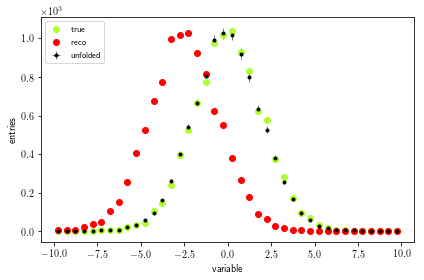

In [8]:
fig = plot_compare_single_run(df_unf, my_bins, 'variable', 'entries')

Looks okay, but not sure if it is the optimal choice of k. Then, we compare some figures of merit of unfolded results among all possible k (k=2..#bins, 1 suggested not good to use). At this moment, six types of FoM are defined: 

a -- $\sum_{i}{|b_{i}|}$ 

b -- $\sum_{i}{|b_{i}|/N_{i}^{\text{true}}}$

c -- $\sum_{i}{b_{i}}$ 

d -- $\sqrt{\sum_{i,j}Cov_{i,j}}$

e -- $\sum_{i}{|b_{i}|}/\sqrt{\sum_{i,j}Cov_{i,j}}$ 

f -- $\sqrt{(\sum_{i}{|b_{i}|})^{2} + \sum_{i,j}Cov_{i,j}}$ 

where $b_{i} = N_{i}^{\text{unfolded}} - N_{i}^{\text{true}}$ is the bias in each bin, and $Cov_{i,j}$ is the covariance matrix from unfolding.

In [9]:
unf_cen_svd, unf_err_svd, fom_a, fom_b, fom_c, fom_d, fom_e, fom_f, fom_k \
= get_fom(hist_test_reco, hist_test_true, respon_matrix, 'Svd')

Use SVD method for error study to compare regularisation parameter k = 2..nins.
SVD init 40 x 40 bins, kreg=2
SVD init 40 x 40 bins, kreg=3
SVD init 40 x 40 bins, kreg=4
SVD init 40 x 40 bins, kreg=5
SVD init 40 x 40 bins, kreg=6
SVD init 40 x 40 bins, kreg=7
SVD init 40 x 40 bins, kreg=8
SVD init 40 x 40 bins, kreg=9
SVD init 40 x 40 bins, kreg=10
SVD init 40 x 40 bins, kreg=11
SVD init 40 x 40 bins, kreg=12
SVD init 40 x 40 bins, kreg=13
SVD init 40 x 40 bins, kreg=14
SVD init 40 x 40 bins, kreg=15
SVD init 40 x 40 bins, kreg=16
SVD init 40 x 40 bins, kreg=17
SVD init 40 x 40 bins, kreg=18
SVD init 40 x 40 bins, kreg=19
SVD init 40 x 40 bins, kreg=20
SVD init 40 x 40 bins, kreg=21
SVD init 40 x 40 bins, kreg=22
SVD init 40 x 40 bins, kreg=23
SVD init 40 x 40 bins, kreg=24
SVD init 40 x 40 bins, kreg=25
SVD init 40 x 40 bins, kreg=26
SVD init 40 x 40 bins, kreg=27
SVD init 40 x 40 bins, kreg=28
SVD init 40 x 40 bins, kreg=29
SVD init 40 x 40 bins, kreg=30
SVD init 40 x 40 bins, kreg=3

Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 2
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.000000
Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 3
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.000010
Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 4
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.000057
Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 5
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.000163
Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 6
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.000406
Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 7
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.000791
Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 8
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.001239
Info in <TSVDUnfold_130729::Unfold>: Unfolding p

So all FoM, the central values and stat. uncertainty of unfolded results are saved with every k. Choose and list the FoM of interest (array, color, label), then we can compare from the plots. Note that the results of all k will be plotted by defaut unless the index of last k to be shown is set. As implied by the SVD author, when take k close to #bins the unfolded resultes could widly oscillate with the amplitude of whole entries.

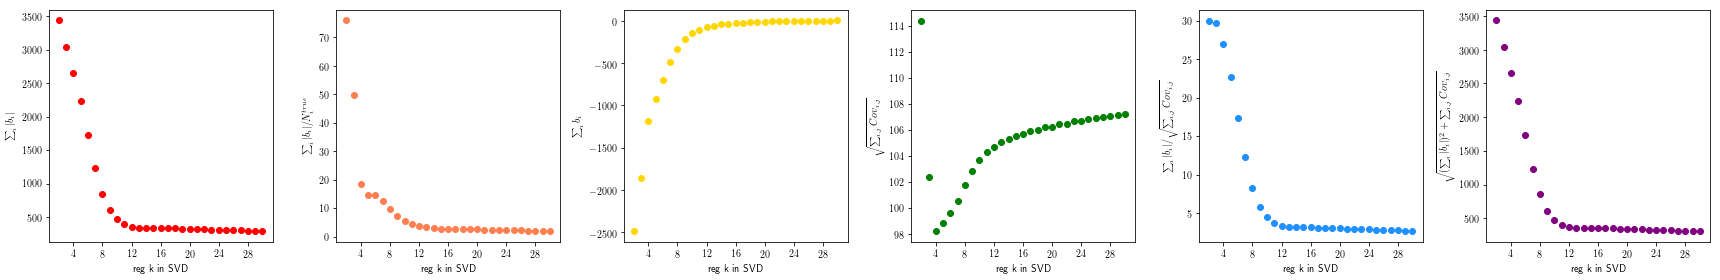

In [12]:
errors    = [fom_a, fom_b, fom_c, fom_d, fom_e, fom_f]

colors    = ['red', 'coral', 'gold', 'green', 'dodgerblue', 'purple', 'hotpink']

err_names = ['$\sum_{i}{|b_{i}|}$', 
             '$\sum_{i}{|b_{i}|/N_{i}^{true}}$',
             '$\sum_{i}{b_{i}}$', 
             '$\sqrt{\sum_{i,j}Cov_{i,j}}$',
             '$\sum_{i}{|b_{i}|}/\sqrt{\sum_{i,j}Cov_{i,j}}$', 
             '$\sqrt{(\sum_{i}{|b_{i}|})^{2} + \sum_{i,j}Cov_{i,j}}$' ]

last_k = 29

# plot all k
#fig_svd_para = plot_compare_para(len(errors), fom_k, 'reg k in SVD', errors, err_names, colors, 'variable')

# plot until last_k
fig_svd_para = plot_compare_para(len(errors), fom_k, 'reg k in SVD', errors, err_names, colors, 'variable', last_k)
#fig_svd_para.savefig('svd_fom.pdf')

It could be interesting to compare many unfolded results together as shown in the following block.

Use matrix invert method for error study.
Use bin-by-bin correction method for error study.


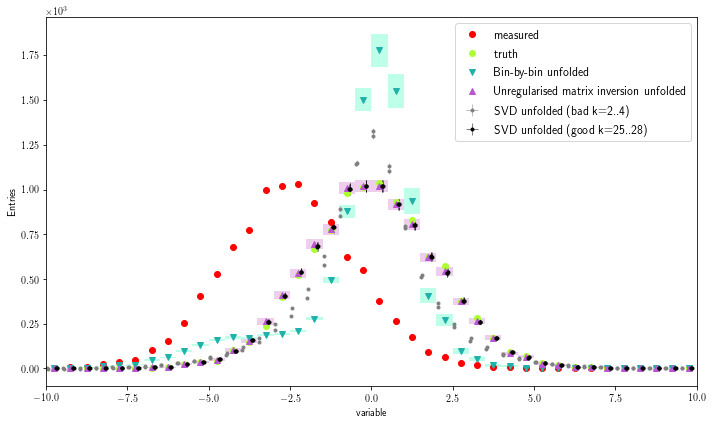

In [20]:
unf_cen_inv, unf_err_inv, inv_fom_a, inv_fom_b, inv_fom_c, inv_fom_d, inv_fom_e, inv_fom_f \
  = get_fom(hist_test_reco, hist_test_true, respon_matrix, 'Invert')
unf_cen_byb, unf_err_byb, byb_fom_a, byb_fom_b, byb_fom_c, byb_fom_d, byb_fom_e, byb_fom_f \
  = get_fom(hist_test_reco, hist_test_true, respon_matrix, 'BinByBin')


truth_cen, truth_err = th1_to_arr(hist_test_true)
measu_cen, measu_err = th1_to_arr(hist_test_reco)

bad_k = range(2, 4)
good_k = range(25, 28)


f = plt.figure(figsize=(10,6))
plt.plot(get_bin_centers(my_bins), measu_cen, marker='o', color='red', ls='', label='measured')
plt.plot(get_bin_centers(my_bins), truth_cen, marker='o', color='greenyellow', ls='', label='truth')

plt.errorbar(x=[], y=[], xerr=[],yerr=[], marker='.', color='gray',ls='', 
             elinewidth=0.5, ecolor='gray',label='SVD unfolded (bad k=2..4)')
plt.errorbar(x=[], y=[], xerr=[],yerr=[], marker='.', color='black',ls='', 
             elinewidth=0.5, ecolor='black',label='SVD unfolded (good k=25..28)')
for x in bad_k:  # loop some bad k from SVD
    plt.errorbar(x=my_bins[:-1]+get_bin_widths(my_bins)/(my_bins.size -1)*(x+1), y=unf_cen_svd[x], \
                 yerr=unf_err_svd[x], xerr=0, marker='.', color='gray',ls='', elinewidth=0.5, ecolor='gray')
for x in good_k:  # loop some good k from SVD
    plt.errorbar(x=my_bins[:-1]+get_bin_widths(my_bins)/(my_bins.size -1)*(x+1), y=unf_cen_svd[x], \
                 yerr=unf_err_svd[x], xerr=0, marker='.', color='black',ls='', elinewidth=0.5, ecolor='black')

plt.plot(get_bin_centers(my_bins), unf_cen_byb, marker='v', color='lightseagreen', ls='', label='Bin-by-bin unfolded')
plt.bar(get_bin_centers(my_bins),
       height=unf_err_byb*2,
       width=get_bin_widths(my_bins),
       bottom=unf_cen_byb - unf_err_byb,
       alpha=0.5, color='aquamarine'
       )  
plt.plot(get_bin_centers(my_bins), unf_cen_inv, marker='^', color='mediumorchid', ls='', label='Unregularised matrix inversion unfolded')
plt.bar(get_bin_centers(my_bins),
       height=unf_err_inv*2,
       width=get_bin_widths(my_bins),
       bottom=unf_cen_inv - unf_err_inv,
       alpha=0.5, color='plum'
       )
plt.xlim(-10,10)
plt.xlabel('variable')
plt.ylabel('Entries')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(loc=1, prop={'size':12})
plt.tight_layout()
plt.show()
plt.close()
#f.savefig('compare_all.pdf')

In the reality, it would be better to have a look at the response matrixt (also called migration matrix) before actual unfolding, e.g. to get some feeling to improve the binning.

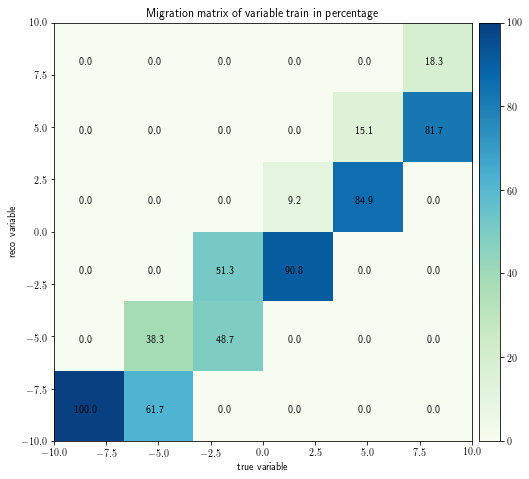

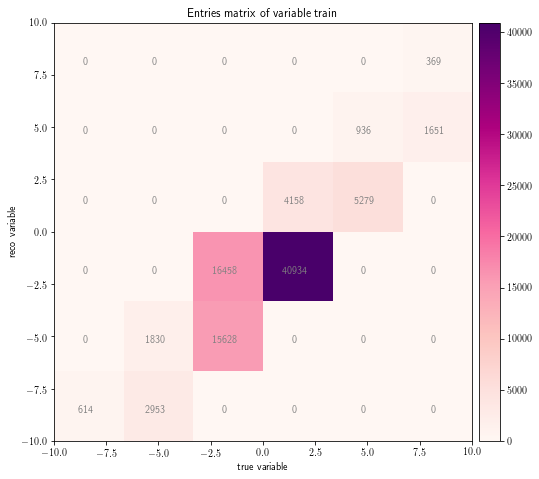

In [15]:
mig_matrix, hist, mig_fig, n_fig = get_migration(
    true_data =df_train['truth'], 
    reco_data =df_train['measured'], 
    weight    =df_train['weight'], 
    bin_var   =np.linspace(-10,10,7), 
    name_var  ='variable', unit_var='', info_var='train', txt_offset=1.5)